In [66]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import gmean
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
gstock_data = pd.read_csv('goog.csv')
gstock_data .head()

,Date,Open,High,Low,Close,Volume
0,12/19/2016,790.219971,797.659973,786.270020,794.200012,1225900
1,12/20/2016,796.760010,798.650024,793.270020,796.419983,925100
2,12/21/2016,795.840027,796.676025,787.099976,794.559998,1208700
3,12/22/2016,792.359985,793.320007,788.580017,791.260010,969100
4,12/23/2016,790.900024,792.739990,787.280029,789.909973,623400


In [68]:
# This will download data from yahoo finance - more than enough for prototyping
gstock_data = yf.download(
        # tickers list or string as well
        tickers = "goog",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5y",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [135]:
gstock_data .tail()

,Open,High,Low,Close,Volume,Close_Diff
Date,,,,,,
2022-02-07,0.926876,0.925679,0.898026,0.892979,0.321440,0.159026
2022-02-08,0.884570,0.889575,0.881383,0.895479,0.233098,0.416175
2022-02-09,0.901236,0.910632,0.913319,0.915845,0.185079,0.532255
2022-02-10,0.889132,0.903928,0.892111,0.889928,0.222535,0.231540
2022-02-11,0.882407,0.884588,0.848714,0.849265,0.271475,0.135722


In [119]:
gstock_data.info()
#gstock_data = gstock_data [['Date','Open','Close']] 
#gstock_data ['Date'] = pd.to_datetime(gstock_data ['Date']) 
#gstock_data .set_index('Date',drop=True,inplace=True) 
gstock_data .head()

gstock_data['Close_Diff']=gstock_data['Close'].diff()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-02-13 to 2022-02-11
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1260 non-null   float64
 1   High        1260 non-null   float64
 2   Low         1260 non-null   float64
 3   Close       1260 non-null   float64
 4   Volume      1260 non-null   float64
 5   Close_Diff  1259 non-null   float64
dtypes: float64(6)
memory usage: 68.9 KB


C:\Users\johnf\AppData\Local\Temp/ipykernel_23216/877230433.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


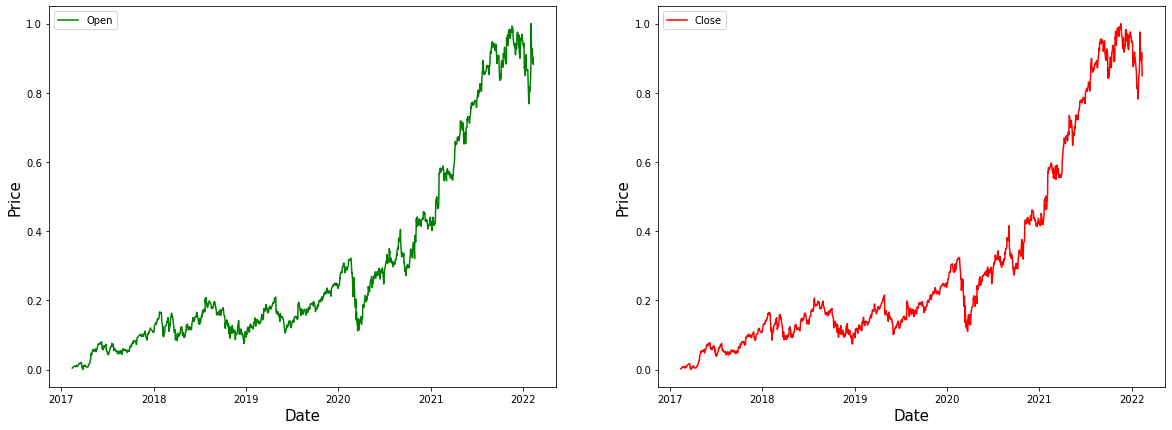

In [136]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(gstock_data['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(gstock_data['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()


fg.show()

In [124]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
gstock_data [gstock_data.columns] = MMS.fit_transform(gstock_data )

In [125]:
training_size = round(len(gstock_data ) * 0.80)

In [126]:
train_data = gstock_data [:training_size]
test_data  = gstock_data [training_size:]


train_data.shape, test_data.shape

((1008, 6), (252, 6))

In [127]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))


In [128]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [129]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((958, 50, 6), (958, 6), (202, 50, 6), (202, 6))

In [130]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [131]:
#pip install tensorflow


In [132]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(6))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 50)            11400     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 31,906
Trainable params: 31,906
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
30/30 [==============================] - 4s 50ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/80
30/30 [==============================] - 1s 31ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/80
30/30 [==============================] - 1s 31ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/80
30/30 [==============================] - 1s 29ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/80
30/30 [==============================] - 1s 29ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/80
30/30 [==============================] - 1s 27ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/80
30/30 [==============================] - 1s 27ms/step - loss: nan - mean_absolute_e

Epoch 55/80
30/30 [==============================] - 1s 26ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 56/80
30/30 [==============================] - 1s 25ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 57/80
30/30 [==============================] - 1s 26ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 58/80
30/30 [==============================] - 1s 25ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 59/80
30/30 [==============================] - 1s 25ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 60/80
30/30 [==============================] - 1s 25ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 61/80
30/30 [==============================] - 1s 24ms/step - loss: nan - mean_abs

In [82]:


test_predicted = model.predict(test_seq)
test_predicted[:5]



array([[0.6637887 , 0.67315024, 0.6692161 , 0.6765515 , 0.21321058],
       [0.6833649 , 0.69693154, 0.6883907 , 0.6964364 , 0.266316  ],
       [0.70066655, 0.7047824 , 0.70903045, 0.7105409 , 0.17933989],
       [0.706475  , 0.7177921 , 0.7113506 , 0.7193695 , 0.2361083 ],
       [0.706886  , 0.7114377 , 0.71290535, 0.7162787 , 0.18317915]],
      dtype=float32)

In [83]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[   2287.4111,    2316.0532,    2271.8843,    2302.674 ,
        1596256.6   ],
       [   2331.0725,    2368.8726,    2313.9607,    2346.416 ,
        1907465.    ],
       [   2369.6604,    2386.3096,    2359.2522,    2377.4424,
        1397767.6   ],
       [   2382.6152,    2415.2046,    2364.3435,    2396.863 ,
        1730441.9   ],
       [   2383.532 ,    2401.0913,    2367.7551,    2390.064 ,
        1420266.5   ]], dtype=float32)

In [85]:
gstock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-02-13 to 2022-02-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1260 non-null   float64
 1   High    1260 non-null   float64
 2   Low     1260 non-null   float64
 3   Close   1260 non-null   float64
 4   Volume  1260 non-null   float64
dtypes: float64(5)
memory usage: 59.1 KB


In [86]:


# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([gstock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','high_predicted','low_predicted','close_predicted','volume_predicted'],index=gstock_data.iloc[-202:].index)], axis=1)



In [89]:


gs_slic_data[['Open','High',"Low",'Close','Volume']] = MMS.inverse_transform(gs_slic_data[['Open','High',"Low",'Close','Volume']]) # Inverse scaling



In [91]:


gs_slic_data.tail()



,Open,High,Low,Close,Volume,open_predicted,high_predicted,low_predicted,close_predicted,volume_predicted
Date,,,,,,,,,,
2022-02-07,2874.179932,2876.929932,2773.979980,2778.760010,2230500.0,2798.889893,2848.898682,2772.274414,2810.821045,1820852.125
2022-02-08,2779.824951,2796.741943,2737.459961,2784.260010,1712800.0,2764.324463,2791.934326,2740.772461,2764.493652,1388357.125
2022-02-09,2816.995117,2843.510010,2807.540039,2829.060059,1431400.0,2717.625977,2756.620117,2686.978271,2719.539795,1561505.250
2022-02-10,2790.000000,2828.620117,2761.000000,2772.050049,1650900.0,2717.801025,2746.294922,2692.576172,2715.518555,1170642.500
2022-02-11,2775.000000,2785.665039,2665.770020,2682.600098,1937700.0,2702.699951,2748.784180,2672.266602,2705.775879,1497417.250


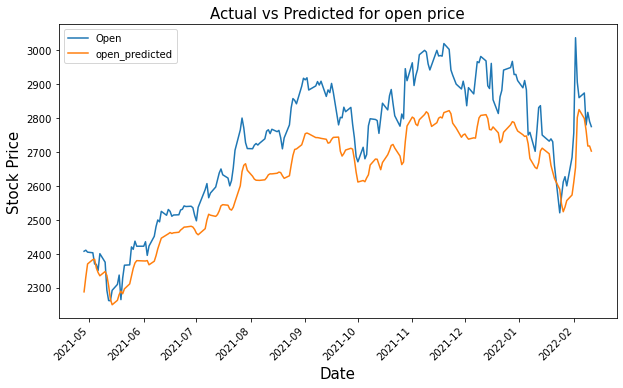

In [137]:


gs_slic_data[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()



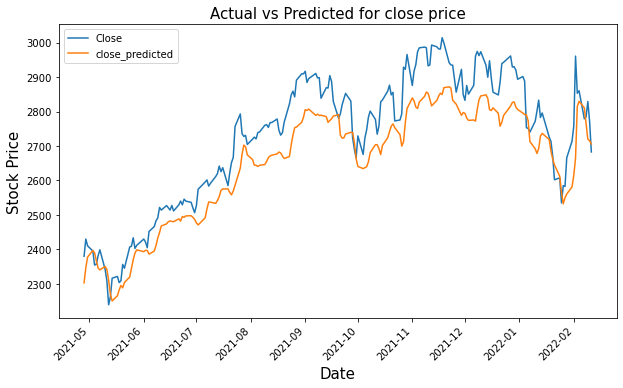

In [95]:


gs_slic_data[['Close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

    

In [96]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))

In [110]:
gs_slic_data.tail(20)

,Open,High,Low,Close,Volume,open_predicted,high_predicted,low_predicted,close_predicted,volume_predicted
2022-01-31,2683.959961,2716.870117,2645.479980,2713.969971,1702800.0,2573.137207,2615.298584,2561.737549,2581.270752,1491057.000
2022-02-01,2756.699951,2764.000000,2691.364990,2757.570068,2560200.0,2611.193115,2641.232910,2603.378174,2614.790771,1243333.875
2022-02-02,3037.270020,3042.000000,2911.149902,2960.729980,4487500.0,2654.538574,2705.550781,2638.718262,2665.017090,1719508.750
2022-02-03,2905.899902,2982.354004,2844.100098,2853.010010,2846500.0,2801.761475,2864.822998,2783.801270,2814.676025,1990063.500
2022-02-04,2860.340088,2890.705078,2796.350098,2860.320068,2458600.0,2825.341553,2853.899658,2813.781006,2829.521729,1326686.875
2022-02-07,2874.179932,2876.929932,2773.979980,2778.760010,2230500.0,2798.889893,2848.898682,2772.274414,2810.821045,1820852.125
2022-02-08,2779.824951,2796.741943,2737.459961,2784.260010,1712800.0,2764.324463,2791.934326,2740.772461,2764.493652,1388357.125
2022-02-09,2816.995117,2843.510010,2807.540039,2829.060059,1431400.0,2717.625977,2756.620117,2686.978271,2719.539795,1561505.250
2022-02-10,2790.000000,2828.620117,2761.000000,2772.050049,1650900.0,2717.801025,2746.294922,2692.576172,2715.518555,1170642.500
2022-02-11,2775.000000,2785.665039,2665.770020,2682.600098,1937700.0,2702.699951,2748.784180,2672.266602,2705.775879,1497417.250


In [108]:
gs_slic_data['2022-02-01':'2021-02-22']

,Open,High,Low,Close,Volume,open_predicted,high_predicted,low_predicted,close_predicted,volume_predicted


In [111]:
upcoming_prediction = pd.DataFrame(columns=['Open','High','Low','Close','Volume'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [112]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

In [113]:


upcoming_prediction[['Open','High','Low','Close','Volume']] = MMS.inverse_transform(upcoming_prediction[['Open','High','Low','Close','Volume']])



In [116]:
upcoming_prediction.tail(20)

,Open,High,Low,Close,Volume
2022-01-31,NaN,NaN,NaN,NaN,NaN
2022-02-01,NaN,NaN,NaN,NaN,NaN
2022-02-02,NaN,NaN,NaN,NaN,NaN
2022-02-03,NaN,NaN,NaN,NaN,NaN
2022-02-04,NaN,NaN,NaN,NaN,NaN
2022-02-07,NaN,NaN,NaN,NaN,NaN
2022-02-08,NaN,NaN,NaN,NaN,NaN
2022-02-09,NaN,NaN,NaN,NaN,NaN
2022-02-10,NaN,NaN,NaN,NaN,NaN
2022-02-11,NaN,NaN,NaN,NaN,NaN


C:\Users\johnf\AppData\Local\Temp/ipykernel_23216/2852754762.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


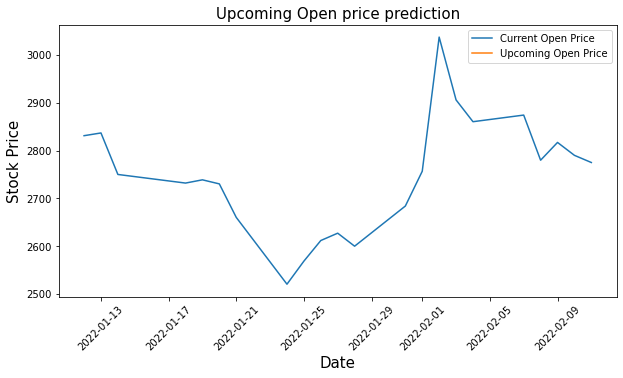

In [114]:


fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2022-01-12':,'Open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2022-02-28':,'Open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()



In [ ]:


fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'Close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'Close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()

